In [166]:
import numpy as np
import matplotlib.pyplot as plt

In [167]:
f1 = '/playpen/Datasets/geodepth2/031/colon_geo_light/nr4/frame029645_disp.npy'
f2 = '/playpen/Downloads/joint/frame029645_disp.npy'

frame1 = np.load(f1)
frame2 = np.load(f2)
print(np.max(frame1), np.max(frame2))

6.641855 6.6418543


In [168]:
name = '000'
number = '027'
normals = np.load(f'/playpen/Datasets/geodepth2/{name}/NFPS/images/{name}_{number}/{name}_{number}_nr_pred.npy')
print(np.min(normals), np.max(normals))
print(normals.shape)

-0.9999998 0.067828216
(216, 270, 3)


(216, 270)
[ 0.01459193 -0.03153901 -0.9993846 ]


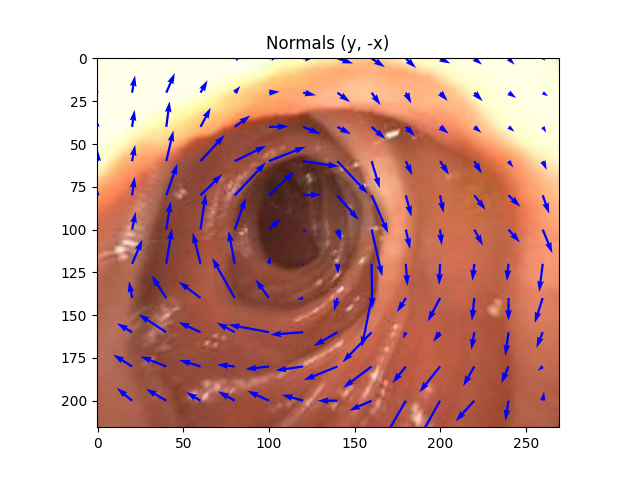

In [181]:
from skimage.io import imread
from glob import glob
from natsort import natsorted
%matplotlib widget

def quiver_image(ax, X, Y, xs, ys, **kwargs):
    ax.quiver(X, Y, xs, -ys, **kwargs)

frame = imread(natsorted(glob(f'/playpen/Datasets/geodepth2/{name}/image/*.jpg'))[int(number)])
frame_normals = frame.copy()
normals_f = normals.copy()
normals_f = np.transpose(normals_f, (2, 0, 1))
print(normals_f[1].shape)

X, Y = np.meshgrid(np.arange(0, normals_f.shape[2], 20), np.arange(0, normals_f.shape[1], 20), indexing='xy')

plt.imshow(frame)
ax = plt.gca()
Q1 = quiver_image(ax, X, Y, normals_f[1][Y, X], -normals_f[0][Y, X], color='blue')

plt.title('Normals (y, -x)')

print(normals_f[:,160,60])

In [170]:
import skimage
import scipy
%matplotlib widget

field = np.stack((normals_f[1], -normals_f[0]), 2)
norms = np.linalg.norm(field, axis=2)
# field[:,:,0] /= norms
# field[:,:,1] /= norms

seg_img_file = f'/playpen/ridge-dtec/run/pascal/mobilenet4-96/ex_4_lucille/results-mine/{name}_frame031221.png'
seg_img = imread(seg_img_file)
seg_img = skimage.transform.resize(seg_img, field.shape[:2])

In [171]:
mask = seg_img[:,:,0]==0
mask = mask.astype(np.uint8)
# edges = mask - scipy.ndimage.morphology.binary_dilation(mask)
# edges = np.minimum(edges, np.ones_like(edges))
# locs = np.where(edges>0)

We want the boundary of the fold region to follow the tangent field as closely as possible, i.e. minimize the average angle between the tangent to the boundary and the tangent field at that location. With the boundary $C=\mathbf{r}(t)$, the minimizer I was trying to use was $$\underset{\mathbf{r}}{\mathrm{arg min}} -\frac{1}{\oint_C ds}\oint_C |\mathbf{F}(\mathbf{r}(t))\cdot \mathbf{T}(t)| ds$$ where $\mathbf{T}(t)$ is the unit tangent vector to the boundary. However, I think this is overly complicated.

As an alternative, we consider $\mathbf{N}$, the field of the projections of surface normals into the imaging plane, which of $\mathbf{F}$ has the property that $\mathbf{F}(\mathbf{x})\cdot \mathbf{N}(\mathbf{x})=0$ for all positions $\mathbf{x}$, by construction, i.e. they are perpendicular. Instead of messing around with absolute values, we use the fact that $|\mathbf{F}\cdot \mathbf{T}|$ is maximized when $\mathbf{N}\cdot \mathbf{T}$ is minimized. This gives us a more straightforward minimizer
$$
\underset{\mathbf{r}}{\mathrm{arg min}} \frac{1}{\oint_C ds}\oint_C \mathbf{N}(\mathbf{r}(t))\cdot \mathbf{r'}(t) dt
$$
which can be rewritten as 
$$
\underset{\mathbf{r}}{\mathrm{arg min}} \frac{1}{\oint_C ds}\oint_C \mathbf{N}(\mathbf{r}(t))\cdot d\mathbf{r}
$$
Minimizing $\mathbf{N}(\mathbf{r}(t))\cdot d\mathbf{r}$ physically corresponds to making the fold region boundary follow the direction of minimum change in the surface normal, or minimum curvature, which is one of the principal directions!

However, computing a line integral along a curve defined by pixels is difficult. It's much easier to compute integrals over area, and we can use Green's Theorem to make this into an area-integral problem:

$$
\underset{\mathbf{r}}{\mathrm{arg min}} \frac{1}{\oint_C ds} \iint_S (\nabla \times \mathbf{N})\cdot dS
$$
where $C=\partial S$.

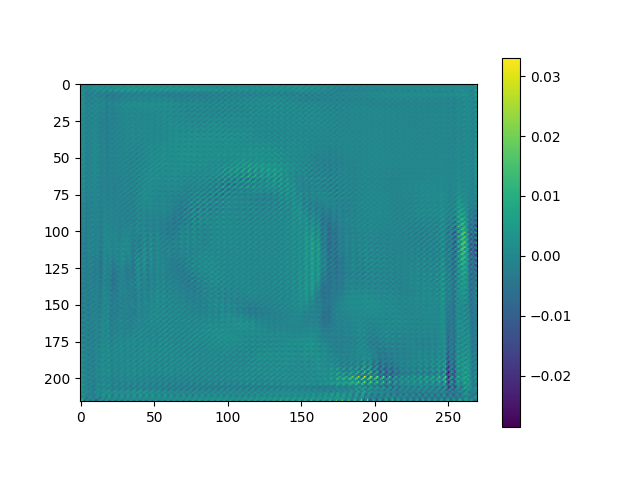

In [182]:
import torch
%matplotlib widget

mask_t = torch.from_numpy(mask)
normals_t = torch.from_numpy(normals_f).permute(1,2,0)

dFxdy = torch.gradient(normals_t[...,1])[0]
dFydx = torch.gradient(normals_t[...,0])[1]
curl = dFxdy-dFydx
plt.imshow(curl)
plt.colorbar()

In [187]:
loss = torch.sum((curl*mask))**2    # squaring to make positive
loss

tensor(32.3226)

In [173]:
def local_tangent(window):
    pts = np.where(window>0)
    if len(pts[0])<2:
        return None
    X = np.stack((np.ones_like(pts[1]), pts[1]), 0).T
    Y = pts[0].reshape(1,-1).T
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    return beta[1,0]

```
%matplotlib widget

locs = np.where(edges[2:-2,2:-2]>0)
tangents = np.zeros((edges.shape[0]-4, edges.shape[1]-4, 2))
for x, y in zip(locs[0], locs[1]):
    window = edges[x:x+5, y:y+5]
    if np.count_nonzero(window)<2:
        continue
    ic, jc = np.where(window==1)
    coords = np.stack((jc, ic), 0)
    mean = np.mean(coords, axis=1)
    slope = np.nan_to_num((np.sum((coords[0]-mean[0])*(coords[1]-mean[1])))/np.sum((coords[0]-mean[0])**2), nan=np.inf)

    if slope is None:
        slope=np.inf
    theta = np.arctan(slope)
    tangents[x, y, 0] = np.cos(theta)
    tangents[x, y, 1] = np.sin(theta)

plt.imshow(frame[2:-2,2:-2], origin='lower')
plt.quiver(locs[1], locs[0], tangents[locs[0], locs[1], 0], tangents[locs[0], locs[1], 1], color='black')

plt.quiver(locs[1], locs[0], field[locs[0]+2, locs[1]+2, 0], field[locs[0]+2, locs[1]+2, 1], color='blue')
```

```
%matplotlib widget

field_cropped = field[2:-2,2:-2]
loss = np.abs(tangents[:,:,0]*field_cropped[:,:,0]+tangents[:,:,1]*field_cropped[:,:,1])/np.count_nonzero(np.sum(tangents**2, axis=2))
plt.imshow(loss, origin='lower')
print(-np.sum(loss))
```

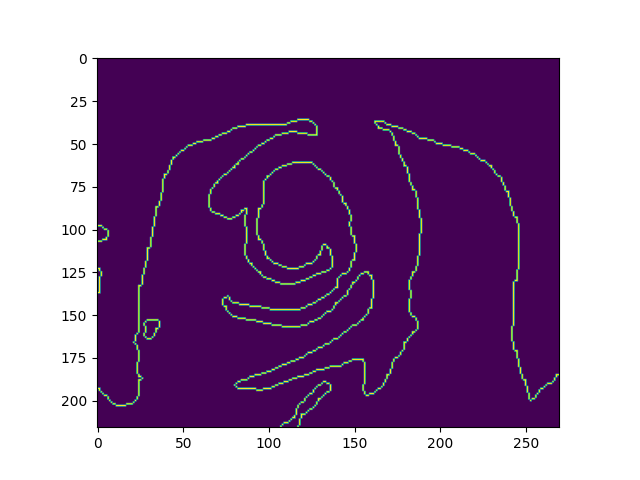

In [174]:
import torch
%matplotlib widget

im = torch.from_numpy(mask.astype(np.uint8)).int()[None,None,...]
kernel = torch.tensor([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]).reshape(1,1,3,3).int()

edges = torch.clamp(torch.nn.functional.conv2d(im, kernel, padding=(1, 1)), 0, 1)-im
plt.imshow(edges[0,0])

windows shape: torch.Size([1, 56392, 5, 5])
windows_on shape: torch.Size([1532, 5, 5])
number of edge pixels: tensor(1532)


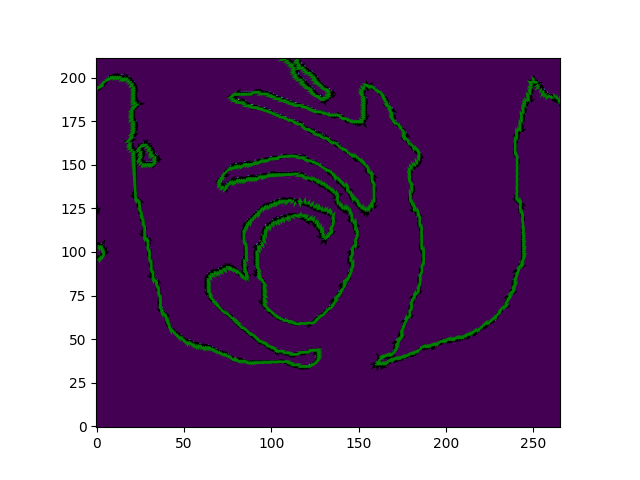

In [116]:
import torch
import torch.nn.functional as F
import torch.nn as nn
%matplotlib widget

side = 2
ks = (2*side+1, 2*side+1)
unfold = nn.Unfold(kernel_size=ks)

edges_cropped = edges[...,side:-side, side:-side]
# edges_cropped = torch.tensor([[0, 0, 0, 1, 0],
#                                 [0, 0, 0, 1, 0],
#                                 [0, 0, 1, 0, 0],
#                                 [0, 0, 1, 0, 0],
#                                 [0, 1, 1, 0, 0]], dtype=torch.int32)
# edges_= F.pad(edges_cropped, (2,2,2,2))[None,None,...]
# print(edges_.shape)

windows = unfold(edges.float())    # edges
locs = torch.where(edges_cropped>0)        # edges_cropped
# print(locs)
windows = windows.permute(0, 2, 1).reshape(windows.shape[0],-1,*ks)

print('windows shape:', windows.shape)

windows_on = windows[locs[0], locs[2]*edges_cropped.shape[-1]+locs[3]].int()
print('windows_on shape:', windows_on.shape)
print('number of edge pixels:', torch.count_nonzero(edges_cropped))

center = (113, 130)     # matrix coordinates in edges (the (216, 270) image)

counts = windows_on.sum(axis=(1,2))
# print(counts[628])
# print(windows_on[628])
ux = torch.arange(-side, side+1).repeat(2*side+1,1)
uy = ux.T
mean = torch.zeros((windows_on.shape[0], 2))
mean[:,0] = (ux*windows_on).sum(axis=(1,2))/counts
mean[:,1] = (uy*windows_on).sum(axis=(1,2))/counts
# print(mean[:,0].repeat(5, 5, 1).permute(2, 0, 1)[628])

xnorm = ux.repeat(len(mean), 1, 1)*windows_on - mean[:,0].repeat(2*side+1, 2*side+1, 1).permute(2, 0, 1)
ynorm = uy.repeat(len(mean), 1, 1)*windows_on - mean[:,1].repeat(2*side+1, 2*side+1, 1).permute(2, 0, 1)
Sx2 = (xnorm**2).sum(axis=(1,2))
Sxy = (xnorm*ynorm).sum(axis=(1,2))
Sy2 = (ynorm**2).sum(axis=(1,2))
theta_ = torch.arctan2(Sxy, Sx2)
theta = torch.arctan2(Sy2-Sx2+torch.sqrt((Sy2-Sx2)**2+4*Sxy**2), 2*Sxy)
theta_[torch.logical_and(Sx2==0, Sxy==0)] = np.pi/2

plt.figure()
plt.quiver(locs[3], locs[2], torch.cos(theta), torch.sin(theta))
plt.quiver(locs[3], locs[2], -torch.cos(theta), -torch.sin(theta))
plt.quiver(locs[3], locs[2], field[locs[2].numpy(), locs[3].numpy(), 0], field[locs[2].numpy(), locs[3].numpy(), 1], color='green')
theta_im = torch.zeros(*edges_cropped.shape[-2:])
theta_im[locs[2], locs[3]] = 1
plt.imshow(theta_im, origin='lower')

# plt.figure()
# plt.quiver(locs[3], locs[2], torch.cos(theta_), torch.sin(theta_))
# plt.quiver(locs[3], locs[2], -torch.cos(theta_), -torch.sin(theta_))
# plt.imshow(theta_im, origin='lower')

In [118]:
vecs = torch.stack((torch.cos(theta), torch.sin(theta)), 1)
field_t = torch.from_numpy(field)[side:-side, side:-side]

((vecs*field_t[locs[2], locs[3]]).abs()/torch.count_nonzero(edges)).sum()

tensor(0.8865)